# Fine-tuning DeBERTa Model for GenAI-Smart City Classification
This notebook demonstrates how to fine-tune the MoritzLaurer/deberta-v3-large-zeroshot-v2.0-c model for classifying text into three categories:

1. "GenAI used for smart city application"
2. "GenAI mentioned, not used"
3. "Not related to GenAI"

In [2]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoModelForSequenceClassification, 
    AutoTokenizer, 
    Trainer, 
    TrainingArguments,
    EarlyStoppingCallback
)
from datasets import load_dataset, Dataset as HFDataset

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else
                     "cuda" if torch.cuda.is_available() else 
                     "cpu")
print(f"Using device: {device}")

# Set paths
DATASET_PATH = "../model/dataset/dataset.json"
OUTPUT_DIR = "../model/output"
DATA_DIR = "../model/dataset"

# Create directories if they don't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

Using device: mps


## Data Loading and Exploration

Dataset shape: (461, 2)

Class distribution:
label
GenAI used for smart city application    181
GenAI mentioned, not used                180
Not related to GenAI                     100
Name: count, dtype: int64

Missing values:
text     0
label    0
dtype: int64

Sample text from each class:

GenAI used for smart city application:
A generative model, specifically a conditional GAN, is used to create synthetic thermal image data for training a model that detects energy inefficiencies in building facades.

GenAI mentioned, not used:
The abstract mentions the potential of using GANs to create synthetic crime incident data for training predictive policing models, but ethical concerns led to using historical data only.

Not related to GenAI:
We built a system for automatically detecting and reporting broken sidewalks using image analysis.


/var/folders/v5/sz3kxfys65g85pv3kjrwzj4r0000gn/T/ipykernel_96576/793434183.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, palette="viridis")


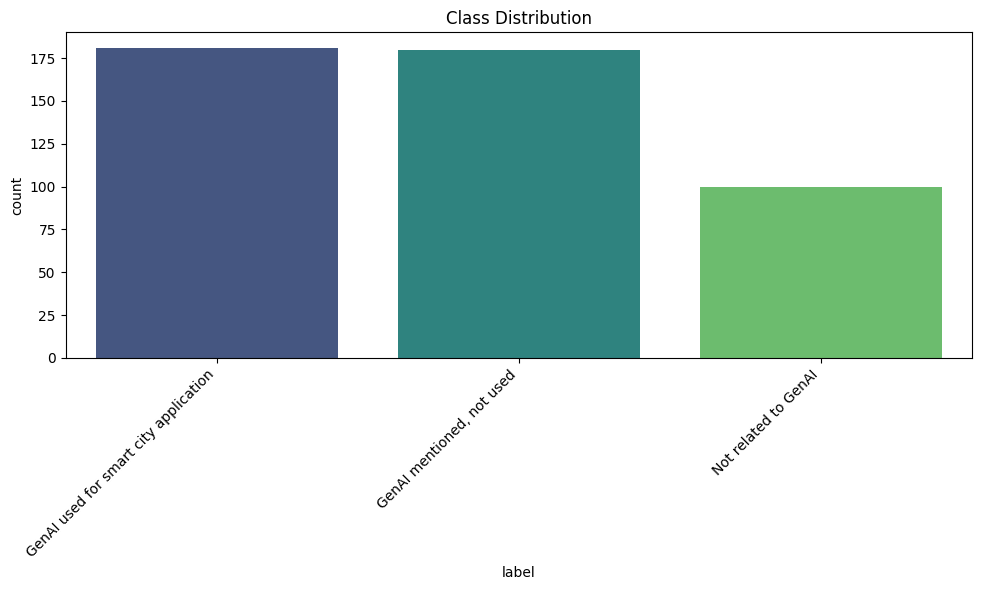

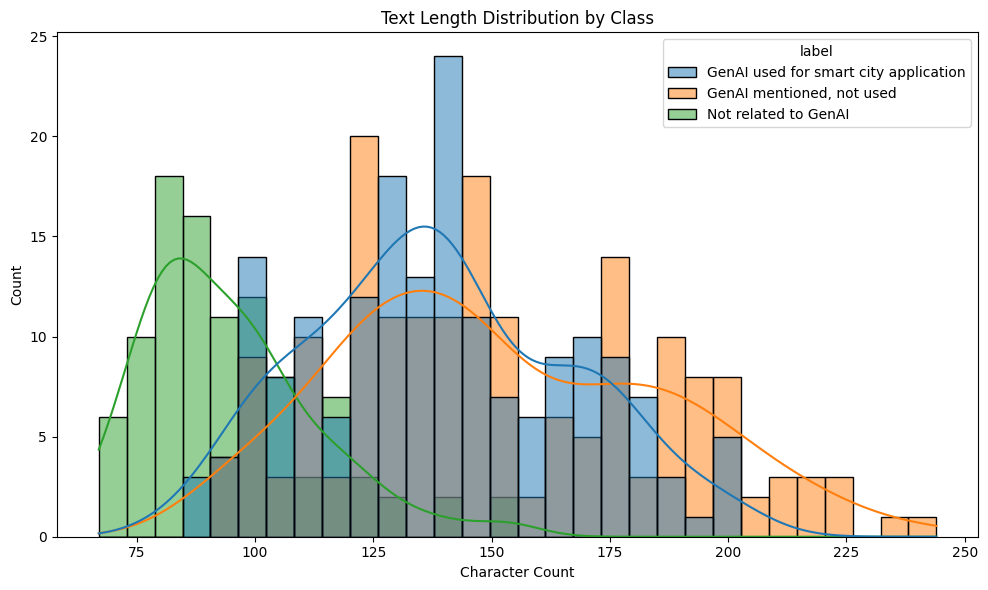

In [3]:
# Load the dataset
with open(DATASET_PATH, "r") as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)

# Display basic info
print(f"Dataset shape: {df.shape}")
print("\nClass distribution:")
print(df["label"].value_counts())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Display sample text from each class
print("\nSample text from each class:")
for label in df["label"].unique():
    sample = df[df["label"] == label].sample(1, random_state=SEED).iloc[0]
    print(f"\n{label}:")
    print(sample["text"])

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x="label", data=df, palette="viridis")
plt.title("Class Distribution")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Text length distribution
df["text_length"] = df["text"].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="text_length", hue="label", bins=30, kde=True)
plt.title("Text Length Distribution by Class")
plt.xlabel("Character Count")
plt.tight_layout()
plt.show()

## Data Preprocessing and Splitting

In [4]:
# Map class labels to integer ids
label_map = {
    "GenAI used for smart city application": 0,
    "GenAI mentioned, not used": 1,
    "Not related to GenAI": 2,
}
id_to_label = {v: k for k, v in label_map.items()}

# Add integer labels
df["label_id"] = df["label"].map(label_map)

# Split data into train (70%), validation (15%), and test (15%) sets
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df["label_id"], random_state=SEED
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label_id"], random_state=SEED
)

print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

# Verify class distribution in splits
print("\nClass distribution in training set:")
print(train_df["label"].value_counts())
print("\nClass distribution in validation set:")
print(val_df["label"].value_counts())
print("\nClass distribution in test set:")
print(test_df["label"].value_counts())

# Create JSON files for each split
train_df[["text", "label"]].to_json(
    os.path.join(DATA_DIR, "train.json"), orient="records", indent=2
)
val_df[["text", "label"]].to_json(
    os.path.join(DATA_DIR, "validation.json"), orient="records", indent=2
)
test_df[["text", "label"]].to_json(
    os.path.join(DATA_DIR, "test.json"), orient="records", indent=2
)

print(f"\nSplit data saved to {DATA_DIR}")

Training set: 322 samples
Validation set: 69 samples
Test set: 70 samples

Class distribution in training set:
label
GenAI mentioned, not used                126
GenAI used for smart city application    126
Not related to GenAI                      70
Name: count, dtype: int64

Class distribution in validation set:
label
GenAI mentioned, not used                27
GenAI used for smart city application    27
Not related to GenAI                     15
Name: count, dtype: int64

Class distribution in test set:
label
GenAI used for smart city application    28
GenAI mentioned, not used                27
Not related to GenAI                     15
Name: count, dtype: int64

Split data saved to ../model/dataset


## Create Model Dataset

In [5]:
# Load tokenizer
model_name = "MoritzLaurer/deberta-v3-large-zeroshot-v2.0-c"
tokenizer = AutoTokenizer.from_pretrained(model_name)


# Create a custom dataset class
class SmartCityGenAIDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long),
        }


# Create datasets
train_dataset = SmartCityGenAIDataset(
    train_df["text"].tolist(), train_df["label_id"].tolist(), tokenizer
)

val_dataset = SmartCityGenAIDataset(
    val_df["text"].tolist(), val_df["label_id"].tolist(), tokenizer
)

test_dataset = SmartCityGenAIDataset(
    test_df["text"].tolist(), test_df["label_id"].tolist(), tokenizer
)

## Model Setup and Training

In [11]:
# Load the model
# model = AutoModelForSequenceClassification.from_pretrained(
#     model_name, num_labels=len(label_map), id2label=id_to_label, label2id=label_map
# )

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_map),
    id2label=id_to_label,
    label2id=label_map,
    ignore_mismatched_sizes=True,  # Add this parameter to handle mismatched sizes
)

use_fp16 = torch.cuda.is_available()  # Only true for NVIDIA GPUs, not for MPS

# Define training arguments
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=5,
    # Reduce batch size significantly
    per_device_train_batch_size=2,
    per_device_eval_batch_size=4,
    # Add gradient accumulation to simulate larger batch sizes
    gradient_accumulation_steps=4,
    # Enable gradient checkpointing to save memory
    gradient_checkpointing=True,
    # Disable mixed precision - just use these flags
    fp16=False,
    bf16=False,
    # Remove the 'mixed_precision' parameter - it's not valid in TrainingArguments
    optim="adamw_torch",
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir=f"{OUTPUT_DIR}/logs",
    logging_steps=20,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    # Disable memory-intensive operations
    report_to="none",
    ddp_find_unused_parameters=False,
    # Force CPU training if MPS is causing issues
    use_cpu=True,  # Try this if MPS is still problematic
)


# Define metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}


# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# Train the model
print("Starting model training...")
trainer.train()

# Save the best model
trainer.save_model(f"{OUTPUT_DIR}/best_model")
print(f"Model saved to {OUTPUT_DIR}/best_model")

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at MoritzLaurer/deberta-v3-large-zeroshot-v2.0-c and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 1024]) in the checkpoint and torch.Size([3, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/v5/sz3kxfys65g85pv3kjrwzj4r0000gn/T/ipykernel_96576/207557762.py:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting model training...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.689400,0.363976,0.942029
2,0.109200,0.002871,1.000000
3,0.091000,0.000488,1.000000
4,0.051700,0.000383,1.000000


RuntimeError: [enforce fail at inline_container.cc:626] . unexpected pos 3172694016 vs 3172693908

## Model Evaluation

Evaluating model on test set...
Test results: {'eval_loss': 0.00038314031553454697, 'eval_accuracy': 1.0}

Classification Report:
                                       precision    recall  f1-score   support

GenAI used for smart city application       1.00      1.00      1.00        28
            GenAI mentioned, not used       1.00      1.00      1.00        27
                 Not related to GenAI       1.00      1.00      1.00        15

                             accuracy                           1.00        70
                            macro avg       1.00      1.00      1.00        70
                         weighted avg       1.00      1.00      1.00        70



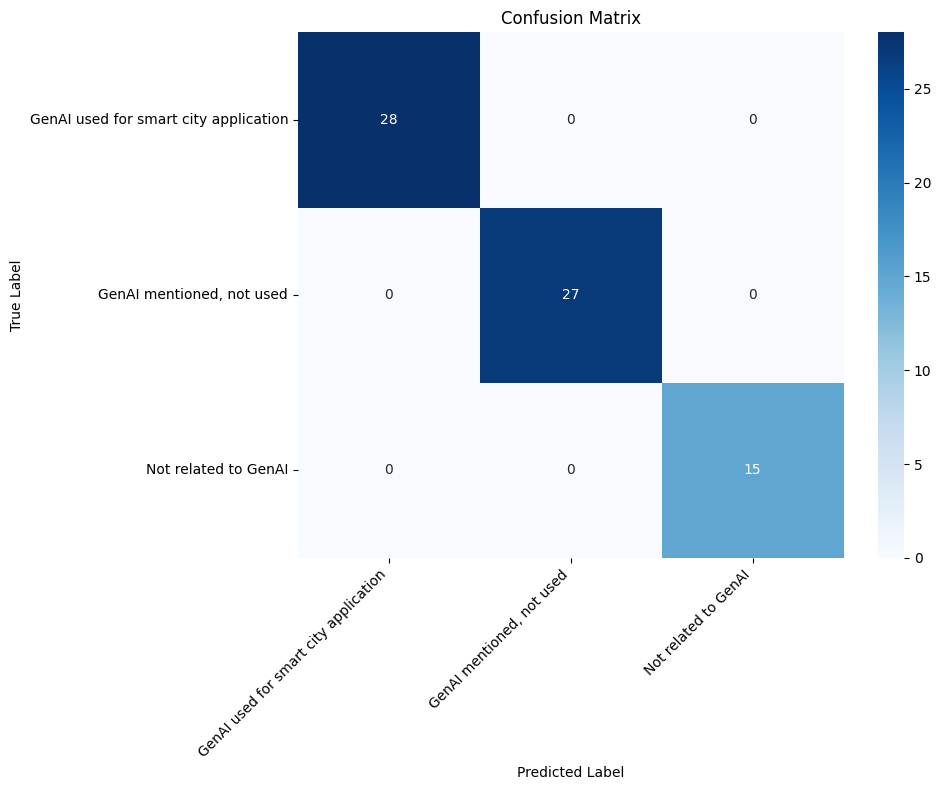

In [12]:
# Evaluate on the test set
print("Evaluating model on test set...")
test_results = trainer.evaluate(test_dataset)
print(f"Test results: {test_results}")

# Get predictions
test_predictions = trainer.predict(test_dataset)
test_preds = np.argmax(test_predictions.predictions, axis=-1)
test_labels = test_predictions.label_ids

# Classification report
print("\nClassification Report:")
print(
    classification_report(test_labels, test_preds, target_names=list(label_map.keys()))
)

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(label_map.keys()),
    yticklabels=list(label_map.keys()),
)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Analysis of Model Predictions

In [ ]:
# Create a DataFrame of predictions vs true labels
results_df = test_df.copy()[["text", "label"]].reset_index(drop=True)
results_df["predicted_label_id"] = test_preds
results_df["predicted_label"] = results_df["predicted_label_id"].map(id_to_label)
results_df["correct"] = results_df["label"] == results_df["predicted_label"]

# Show misclassified examples
misclassified = results_df[~results_df["correct"]]
print(
    f"Number of misclassified examples: {len(misclassified)} out of {len(test_df)} test samples"
)

# Show some misclassified examples
print("\nSample of misclassified examples:")
for i, row in misclassified.head(5).iterrows():
    print(f"\nText: {row['text'][:150]}...")
    print(f"True label: {row['label']}")
    print(f"Predicted label: {row['predicted_label']}")
    print("---")

# Analysis by text length
plt.figure(figsize=(10, 6))
sns.boxplot(x="label", y="text_length", hue="correct", data=results_df)
plt.title("Prediction Correctness by Text Length and Class")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Inference Example

In [ ]:
# Create an inference function
def predict_genai_application(text, model=None, tokenizer=None):
    if model is None:
        model = AutoModelForSequenceClassification.from_pretrained(
            f"{OUTPUT_DIR}/best_model"
        )
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model.to(device)

    # Tokenize the input
    inputs = tokenizer(
        text, truncation=True, padding="max_length", max_length=256, return_tensors="pt"
    ).to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        predicted_class_id = torch.argmax(probabilities, dim=-1).item()

    predicted_label = id_to_label[predicted_class_id]
    probabilities = probabilities.cpu().numpy()[0]

    return {
        "predicted_label": predicted_label,
        "probabilities": {
            id_to_label[i]: float(prob) for i, prob in enumerate(probabilities)
        },
    }


# Test inference on sample texts
sample_texts = [
    "We implemented a GPT-4 based system to optimize traffic light timings across the city center.",
    "The literature review discusses various generative AI approaches but our implementation uses traditional statistical methods.",
    "The city council approved a new budget for improving pedestrian walkways in the downtown area.",
]

for text in sample_texts:
    result = predict_genai_application(text)
    print(f"\nText: {text}")
    print(f"Predicted label: {result['predicted_label']}")
    print("Probabilities:")
    for label, prob in result["probabilities"].items():
        print(f"  {label}: {prob:.4f}")

## Save Model Files for Deployment

In [ ]:
# Save model configuration
model_config = {
    "model_name": model_name,
    "num_labels": len(label_map),
    "id2label": id_to_label,
    "label2id": label_map,
    "max_length": 256,
}

with open(f"{OUTPUT_DIR}/model_config.json", "w") as f:
    json.dump(model_config, f, indent=2)

# Create a simplified inference script
inference_script = """
import json
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

class GenAIClassifier:
    def __init__(self, model_path, config_path):
        # Load configuration
        with open(config_path, 'r') as f:
            self.config = json.load(f)
        
        # Set device
        self.device = torch.device("cuda" if torch.cuda.is_available() else 
                                  "mps" if torch.backends.mps.is_available() else
                                  "cpu")
        
        # Load model and tokenizer
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = AutoTokenizer.from_pretrained(self.config['model_name'])
        self.model.to(self.device)
        
    def predict(self, text):
        # Tokenize
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.config['max_length'],
            return_tensors='pt'
        ).to(self.device)
        
        # Get predictions
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
            probabilities = torch.nn.functional.softmax(logits, dim=-1)
            predicted_class_id = torch.argmax(probabilities, dim=-1).item()
        
        predicted_label = self.config['id2label'][str(predicted_class_id)]
        probabilities = probabilities.cpu().numpy()[0]
        
        return {
            'predicted_label': predicted_label,
            'probabilities': {self.config['id2label'][str(i)]: float(prob) 
                             for i, prob in enumerate(probabilities)}
        }

# Example usage
if __name__ == "__main__":
    classifier = GenAIClassifier("../model/output/best_model", "../model/output/model_config.json")
    
    # Test with a sample text
    sample_text = "We implemented a large language model to generate traffic predictions."
    result = classifier.predict(sample_text)
    print(f"Text: {sample_text}")
    print(f"Prediction: {result['predicted_label']}")
    print("Probabilities:")
    for label, prob in result['probabilities'].items():
        print(f"  {label}: {prob:.4f}")
"""

with open(f"{OUTPUT_DIR}/inference.py", "w") as f:
    f.write(inference_script)

print(f"Inference script saved to {OUTPUT_DIR}/inference.py")
print("Model training and evaluation complete!")

## Analyze Challenging Cases and Model Limitations

In [ ]:
# Find examples where the model was least confident
results_df["max_prob"] = test_predictions.predictions.max(axis=1)
low_confidence = results_df.sort_values("max_prob").head(10)

print("Examples with low confidence predictions:")
for i, row in low_confidence.iterrows():
    print(f"\nText: {row['text'][:150]}...")
    print(f"True label: {row['label']}")
    print(
        f"Predicted label: {row['predicted_label']} (confidence: {row['max_prob']:.4f})"
    )
    print("---")

# Analyze predictions by GenAI technology mentioned
genai_keywords = [
    "transformer",
    "gpt",
    "llm",
    "gan",
    "diffusion",
    "vae",
    "large language model",
    "generative adversarial",
    "variational autoencoder",
]


def contains_keyword(text, keywords):
    return any(keyword.lower() in text.lower() for keyword in keywords)


results_df["contains_genai_keyword"] = results_df["text"].apply(
    lambda x: contains_keyword(x, genai_keywords)
)

# Analyze prediction accuracy by presence of GenAI keyword
keyword_accuracy = results_df.groupby("contains_genai_keyword")["correct"].mean()
print("\nPrediction accuracy by presence of GenAI keyword:")
print(keyword_accuracy)

# Visualize
plt.figure(figsize=(8, 6))
sns.barplot(x=keyword_accuracy.index, y=keyword_accuracy.values)
plt.title("Model Accuracy by Presence of GenAI Keywords")
plt.xlabel("Contains GenAI Keyword")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()